## Part 1 ##

# Training a Sequential CNN to classify Handwritten digits #

In the following cells,a sequential convolutional neural netwwork is trained to classify handwritten digits with a significant accuracy. This will be needed to extract digits from the images to and produce input to feed into the neural network.

The keras utitilies are used to build the CNN

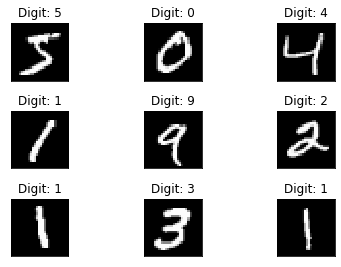

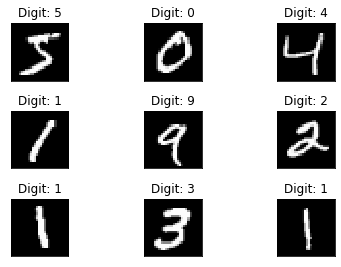

In [2]:
#Loading in the important libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from tensorflow.keras.layers import Dense, Dropout, Flatten # core layers

#Working with the CPU as my personal system does not contain a GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

#Importing keras functions and MNIST dataset for handwritten digit classification
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = mnist.load_data()


# Looking at the Data

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [3]:
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

y_test shape (10000,)
Train matrix shape (60000, 28, 28, 1)
Test matrix shape (10000, 28, 28, 1)


In [4]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [5]:
# building a linear stack of layers with the sequential model
model = Sequential()

## Declare the layers
layer_1 = Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1))
layer_2 = Conv2D(64, kernel_size=3, activation='relu')
layer_3 = Flatten()
layer_4 = Dense(10, activation='softmax')

## Add the layers to the model
model.add(layer_1)
model.add(layer_2)
model.add(layer_3)
model.add(layer_4)


In [6]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

In [7]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))

# saving the model
save_dir = "/results/"
model_name = 'sudokucnn.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_name)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

Epoch 1/20


KeyboardInterrupt: 

## Conclusion of Part 1 ##

In this part, a CNN for identifying hand written digits was trained.

Accuracy Achieved ~ 98%

Which is sufficient to train a fairly well performing sudoku solver




_______________________________________________________________________________________________________________________________



## Part 2 ##
# Using OpenCV for Image Processing #

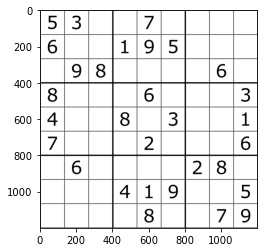

In [3]:
img = cv2.imread('sudoku2.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray,cmap ='gray')

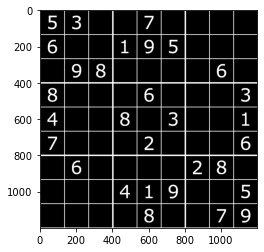

In [4]:
dst = cv2.GaussianBlur(gray,(1,1),cv2.BORDER_DEFAULT)
ret,thresh_inv = cv2.threshold(gray, 180, 255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh_inv,cmap='gray')

In [5]:
minLineLength = 100
maxLineGap = 60
lines = cv2.HoughLinesP(thresh_inv,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
for l in lines:
    x1,y1,x2,y2 = l[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2, cv2.LINE_AA)
cv2.imwrite('hough.jpg',img)

True

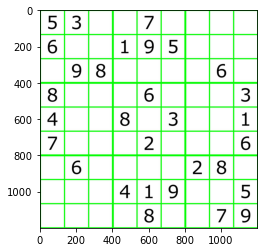

In [6]:
img_hough = cv2.imread('hough.jpg',0)
img_show = cv2.imread('hough.jpg')
plt.imshow(img_show, cmap='gray')

In [7]:
contours,hierarchy = cv2.findContours(img_hough,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [8]:
# find the biggest area
cnt = contours[0]
max_area = cv2.contourArea(cnt)

for cont in contours:
    if cv2.contourArea(cont) > max_area:
        cnt = cont
        max_area = cv2.contourArea(cont)

max_area

1437601.0

In [9]:
epsilon = 0.01*cv2.arcLength(cnt,True)
poly_approx = cv2.approxPolyDP(cnt, epsilon, True)
poly_approx

array([[[   0,    0]],

       [[   0, 1199]],

       [[1199, 1199]],

       [[1199,    0]]], dtype=int32)

In [10]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[0]
    rect[2] = pts[2]
    
    diff = np.diff(pts, axis = 1)
    rect[3] = pts[3]
    rect[1] = pts[1]
    
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([[0, 0], [0, maxHeight - 1],[maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [11]:
img_PT = four_point_transform(thresh_inv,poly_approx)
img_PT.shape

(1199, 1199)

True

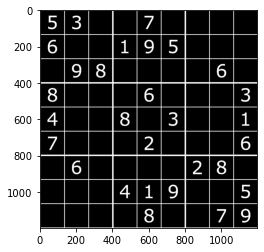

In [12]:
plt.imshow(img_PT, cmap='gray')
cv2.imwrite('img_PT.jpg',img)

In [13]:
from tensorflow.keras.models import load_model
new_model = load_model('sudokucnn.h5')


In [14]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

In [15]:
def prediction(test_image):
    
    classes = new_model.predict_classes(test_image)
    
    if classes == [[0]]:
        return 0
    elif classes == [[1]]:
        return 1
    elif classes == [[2]]:
        return 2
    elif classes == [[3]]:
        return 3
    elif classes == [[4]]:
        return 4
    elif classes == [[5]]:
        return 5
    elif classes == [[6]]:
        return 6
    elif classes == [[7]]:
        return 7
    elif classes == [[8]]:
        return 8
    elif classes == [[9]]:
        return 9

In [16]:
import tensorflow as tf
from PIL import Image

In [17]:
#creating a function to get the different position of cells
def getCellPositions(img_PT):
    #resizing the images to take the shape of the NN model
    img_PT = cv2.resize(img,(255,255))
    #computing position of each cell and storing in an array of arrays
    cell_positions = []
    
    width = img_PT.shape[1]
    height = img_PT.shape[0]
    
    cell_width = width//9
    cell_height = height//9
    
    x1,x2,y1,y2 = 0,0,0,0
    
    for i in range(9):
        y2 = y1 + cell_height
        x1 = 0
        for j in range(9):
            x2 = x1 + cell_width
            current_cell = [x1,x2,y1,y2]
            cell_positions.append(current_cell)
            x1 = x2
        y1 = y2
    return cell_positions

#using the trained model to predict the digits in each cell, if cell is empty fix with 0
def predictDigit(cell,img):
    pos = []
    img = cv2.resize(img,(252,252))
    img = img[cell[2]+2:cell[3]-3,cell[0]+2:cell[1]-3]
    contours,hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0:

        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            # if the contour is sufficiently large, it must be a digit
            if (w < 15 and x > 2) and (h < 25 and y > 2):#multiplied each number by 9 due to the resized image
                #pos = (x,y,x+w,y+h)
                pos.append((x,y,x+w,y+h))
                break
    if pos == []:
        result = 0
    if pos:
        img1 = img[(pos[0][1]):(pos[0][3]),(pos[0][0]):(pos[0][2])]
        #img1 = img[4:25,5:23]
        #22-3-2020
        img1 = cv2.resize(img,(28,28))
        img1 = img1.reshape(1,28,28,1)
        img1 = tf.cast(img1, tf.float32) #for linux (tf2.0)

        result = prediction(img1)
        
    return result

In [18]:
def extractSudokuDigits(img_PT):
    #we start looking at the middle of the cell as this is where the sudoku digit should be at
    cell_digits,num = [],0
    cells = getCellPositions(img_PT)
    for cell in range(len(cells)):
        num = predictDigit(cells[cell],img_PT)
        cell_digits.append(num)
    n = 9
    cell_digits = [cell_digits[i:i+n] for i in range(0, len(cell_digits), n)] 
    return cell_digits

(599, 602)

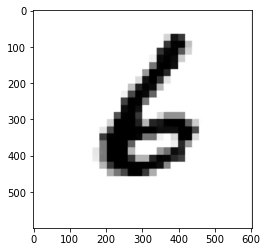

In [19]:
test_image = cv2.imread('sixtest.png',0) #reading in grayscale
plt.imshow(test_image,cmap='gray')
test_image.shape

In [20]:
new_model = load_model('sudokucnn.h5')

In [21]:
from keras.preprocessing import image

ret, thresh = cv2.threshold(test_image.copy(), 75, 255, cv2.THRESH_BINARY_INV)
resized_digit = cv2.resize(thresh, (28,28))
resized_digit = resized_digit.reshape(1,28,28,1)
resized_digit = tf.cast(resized_digit, tf.float32) #for linux (tf2.0)

In [22]:
prediction(resized_digit)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


6

In [23]:
#testing the extraction process for one sudoku picture
board = extractSudokuDigits(img_PT)
board


[[5, 3, 0, 0, 7, 0, 0, 0, 0],
 [6, 0, 0, 1, 9, 5, 0, 0, 0],
 [0, 9, 8, 0, 0, 0, 0, 6, 0],
 [8, 0, 0, 0, 6, 0, 0, 0, 3],
 [4, 0, 0, 8, 0, 3, 0, 0, 1],
 [7, 0, 0, 0, 2, 0, 0, 0, 6],
 [0, 6, 0, 0, 0, 0, 2, 8, 0],
 [0, 0, 0, 4, 1, 9, 0, 0, 5],
 [0, 0, 0, 0, 8, 0, 0, 7, 9]]

## IMPLEMENTING BACKTRACKING ALGORITHM AND VISUALISING TOOL FOR SOLVING THE SUDOKU BOARD ##

In [24]:
import pygame

 
# initialise the pygame font
pygame.font.init()
 
# Total window
screen = pygame.display.set_mode((500, 600))
 
# Title and Icon
pygame.display.set_caption("SUDOKU SOLVER USING BACKTRACKING")

 
x = 0
y = 0
dif = 500 / 9
val = 0
# Default Sudoku Board.
grid = board
numpy_array = np.array(grid)
transpose = numpy_array.T
grid = transpose.tolist()
gridbackup = grid
 
# Load test fonts for future use
font1 = pygame.font.SysFont("comicsans", 40)
font2 = pygame.font.SysFont("comicsans", 20)
def get_cord(pos):
    global x
    x = pos[0]//dif
    global y
    y = pos[1]//dif
 
# Highlight the cell selected
def draw_box():
    for i in range(2):
        pygame.draw.line(screen, (255, 0, 0), (x * dif-3, (y + i)*dif), (x * dif + dif + 3, (y + i)*dif), 7)
        pygame.draw.line(screen, (255, 0, 0), ( (x + i)* dif, y * dif ), ((x + i) * dif, y * dif + dif), 7)  
 
# Function to draw required lines for making Sudoku grid        
def draw():
    # Draw the lines
        
    for i in range (9):
        for j in range (9):
            if grid[i][j]!= 0:
 
                # Fill blue color in already numbered grid
                pygame.draw.rect(screen, (0, 153, 153), (i * dif, j * dif, dif + 1, dif + 1))
 
                # Fill gird with default numbers specified
                text1 = font1.render(str(grid[i][j]), 1, (0, 0, 0))
                screen.blit(text1, (i * dif + 15, j * dif + 15))
    # Draw lines horizontally and verticallyto form grid          
    for i in range(10):
        if i % 3 == 0 :
            thick = 7
        else:
            thick = 1
        pygame.draw.line(screen, (0, 0, 0), (0, i * dif), (500, i * dif), thick)
        pygame.draw.line(screen, (0, 0, 0), (i * dif, 0), (i * dif, 500), thick)     
 
# Fill value entered in cell     
def draw_val(val):
    text1 = font1.render(str(val), 1, (0, 0, 0))
    screen.blit(text1, (x * dif + 15, y * dif + 15))   
 
# Raise error when wrong value entered
def raise_error1():
    text1 = font1.render("WRONG !!!", 1, (0, 0, 0))
    screen.blit(text1, (20, 570)) 
def raise_error2():
    text1 = font1.render("Wrong !!! Not a valid Key", 1, (0, 0, 0))
    screen.blit(text1, (20, 570)) 
 
# Check if the value entered in board is valid
def valid(m, i, j, val):
    for it in range(9):
        if m[i][it]== val:
            return False
        if m[it][j]== val:
            return False
    it = i//3
    jt = j//3
    for i in range(it * 3, it * 3 + 3):
        for j in range (jt * 3, jt * 3 + 3):
            if m[i][j]== val:
                return False
    return True
 
# Solves the sudoku board using Backtracking Algorithm
def solve(grid, i, j):
     
    while grid[i][j]!= 0:
        if i<8:
            i+= 1
        elif i == 8 and j<8:
            i = 0
            j+= 1
        elif i == 8 and j == 8:
            return True
    pygame.event.pump()   
    for it in range(1, 10):
        if valid(grid, i, j, it)== True:
            grid[i][j]= it
            global x, y
            x = i
            y = j
            # white color background\
            screen.fill((255, 255, 255))
            draw()
            draw_box()
            pygame.display.update()
            pygame.time.delay(20)
            if solve(grid, i, j)== 1:
                return True
            else:
                grid[i][j]= 0
            # white color background\
            screen.fill((255, 255, 255))
         
            draw()
            draw_box()
            pygame.display.update()
            pygame.time.delay(50)   
    return False 
 
# Display instruction for the game
def instruction():
    text1 = font2.render("PRESS D TO RESET TO DEFAULT / R TO EMPTY", 1, (0, 0, 0))
    text2 = font2.render("ENTER VALUES AND PRESS ENTER TO VISUALIZE", 1, (0, 0, 0))
    screen.blit(text1, (20, 520))       
    screen.blit(text2, (20, 540))
 
# Display options when solved
def result():
    text1 = font1.render("FINISHED PRESS R or D", 1, (0, 0, 0))
    screen.blit(text1, (20, 570))   
run = True
flag1 = 0
flag2 = 0
rs = 0
error = 0
# The loop thats keep the window running
while run:
     
    # White color background
    screen.fill((255, 255, 255))
    # Loop through the events stored in event.get()
    for event in pygame.event.get():
        # Quit the game window
        if event.type == pygame.QUIT:
            run = False 
        # Get the mouse position to insert number   
        if event.type == pygame.MOUSEBUTTONDOWN:
            flag1 = 1
            pos = pygame.mouse.get_pos()
            get_cord(pos)
        # Get the number to be inserted if key pressed   
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_LEFT:
                x-= 1
                flag1 = 1
            if event.key == pygame.K_RIGHT:
                x+= 1
                flag1 = 1
            if event.key == pygame.K_UP:
                y-= 1
                flag1 = 1
            if event.key == pygame.K_DOWN:
                y+= 1
                flag1 = 1   
            if event.key == pygame.K_1:
                val = 1
            if event.key == pygame.K_2:
                val = 2   
            if event.key == pygame.K_3:
                val = 3
            if event.key == pygame.K_4:
                val = 4
            if event.key == pygame.K_5:
                val = 5
            if event.key == pygame.K_6:
                val = 6
            if event.key == pygame.K_7:
                val = 7
            if event.key == pygame.K_8:
                val = 8
            if event.key == pygame.K_9:
                val = 9 
            if event.key == pygame.K_RETURN:
                flag2 = 1  
            # If R pressed clear the sudoku board
            if event.key == pygame.K_r:
                rs = 0
                error = 0
                flag2 = 0
                grid =[
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0]
                ]
            # If D is pressed reset the board to default
            if event.key == pygame.K_d:
                rs = 0
                error = 0
                flag2 = 0
                grid = gridbackup
    if flag2 == 1:
        if solve(grid, 0, 0)== False:
            error = 1
        else:
            rs = 1
        flag2 = 0   
    if val != 0:           
        draw_val(val)
        # print(x)
        # print(y)
        if valid(grid, int(x), int(y), val)== True:
            grid[int(x)][int(y)]= val
            flag1 = 0
        else:
            grid[int(x)][int(y)]= 0
            raise_error2()  
        val = 0   
       
    if error == 1:
        raise_error1() 
    if rs == 1:
        result()       
    draw() 
    if flag1 == 1:
        draw_box()      
    instruction()   
 
    # Update window
    pygame.display.update() 
 
# Quit pygame window   
pygame.quit() 

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


KeyboardInterrupt: 

In [ ]:
=